In [1]:
from IGraph import *
from AbstractGraph import *
from UGraphModel import *
from DGraphModel import *
#from BayesNet import *

In [4]:
model = DGraphModel()
for idx in range(10):
    model.add(str(idx))

model.connect('0', '1')
model.connect('0', '5')
model.connect('1', '7')
model.connect('3', '2')
model.connect('3', '4')
model.connect('3', '7')
model.connect('3', '8')
model.connect('4', '8')
model.connect('6', '0')
model.connect('6', '1')
model.connect('6', '2')
model.connect('8', '2')
model.connect('8', '7')
model.connect('9', '4')
model.println()

TypeError: add() missing 1 required positional argument: 'tableProb'

In [2]:
DFS = 0
BFS = 1
sorter = TopoSorter(model)
topo = sorter.sort(BFS)
print("topoBFS:", topo)

topo = sorter.sort(DFS)
print("topoDFS:", topo)

NameError: name 'model' is not defined

In [2]:
import numpy as np
import time

In [3]:
import random

In [4]:
random.seed(10)

In [5]:
class ConditionalProbabilityTable():
    def __init__(self,initTable,initParents,initNodeName):
        self.initTable = initTable
        TableShape = np.array(initTable).T.shape
        self.ProbabilityTable = np.array(initTable).T[:-1].reshape(TableShape[0]-1,TableShape[1])
        self.ProbabilityTableValues = np.array(initTable).T[-1].astype(np.float)
        self.ParentsList = initParents
        self.NodeName = initNodeName
        self.SortTable , self.SortValues =  self.SortMax2MinProb( self.ProbabilityTable[0] , self.ProbabilityTableValues )
        if self.isDiscreteDistribution() == False:
            AllParentsKey = np.unique(np.array(initTable)[:,:-2],axis=0)
            self.DictofMinTable = {}
            for i in range(AllParentsKey.shape[0]):
                QueryDict = {}
                KeyDict   = ""
                for j in range(AllParentsKey.shape[1]):
                    QueryDict[self.ParentsList[j]] = AllParentsKey[i,j]
                    KeyDict += self.ParentsList[j]+str(AllParentsKey[i,j])
                self.DictofMinTable[KeyDict] =  self.getNodeProbability(QueryDict)

            self.ParentsNum = len(initParents)
            if self.ProbabilityTable.shape[0]-1 != self.ParentsNum:
                raise NameError("Init failed, number of parents is wrong!")
        
    def getValueList(self):
        return list(set(self.ProbabilityTable[-1]))

    def isDiscreteDistribution(self):
        if len(self.ParentsList) ==  1 and self.ParentsList[0] == "":
            return True
        else:
            return False
    
    def SortMax2MinProb(self,RunTable,ValueTable):
        SortMax2MinIndex = ValueTable.argsort()[::-1]
        return RunTable[SortMax2MinIndex], ValueTable[SortMax2MinIndex]
    
    def getNodeProbability(self,ParentState):
        RunTable = self.ProbabilityTable
        ValueTable = self.ProbabilityTableValues
        for name in self.ParentsList:
            if name in ParentState:
                State = np.array(ParentState[name])
                index = np.where( RunTable[0] == State )[0]
                RunTable = RunTable[1:,index] 
                ValueTable = ValueTable[index]
            else:
                raise NameError("Parents state is not enough")
            
        return self.SortMax2MinProb ( RunTable[0], ValueTable )
    
    def getNodeProbabilityImmediately(self,ParentState):
        KeyDict = ""
        for name in self.ParentsList:
            if name in ParentState:
                KeyDict += name+str(ParentState[name])
            else:
                raise NameError("Parents state is not enough")
        return self.DictofMinTable[KeyDict]
    
    def getOutput(self,ParentState):
        if self.isDiscreteDistribution(): 
            NodeProba,ValueTable = self.SortTable , self.SortValues
        else:
            NodeProba,ValueTable = self.getNodeProbabilityImmediately(ParentState)     
            
        RandomValue = random.random()
        ProbThreshold = 0
        for index in range(len(NodeProba)):
            ProbThreshold += ValueTable[index]
            if RandomValue < ProbThreshold:
                ParentState[self.NodeName] = NodeProba[index]
                return ParentState
        
    def getOutputWithLikehood(self, ParentState, ParentLikelihoodWeight, Observations):
        if self.NodeName not in Observations.keys():
            if self.isDiscreteDistribution():   
                NodeProba,ValueTable = self.SortTable , self.SortValues
            else:
                NodeProba,ValueTable = self.getNodeProbabilityImmediately(ParentState)
            # Sampling
            RandomValue = random.random()
            ProbThreshold = 0
            for index in range(len(NodeProba)):
                ProbThreshold += ValueTable[index]
                if RandomValue < ProbThreshold:
                    ParentState[self.NodeName] = NodeProba[index]    
                    return ParentState, ParentLikelihoodWeight
        else:
            
            if self.isDiscreteDistribution():   
                NodeProba, ValueTable = self.SortTable , self.SortValues
            else:
                NodeProba,ValueTable = self.getNodeProbabilityImmediately(ParentState)
            # No need sampling    
            for index in range(len(NodeProba)):
                if NodeProba[index] == Observations[self.NodeName]:
                    ParentState[self.NodeName] = NodeProba[index]
                    ParentLikelihoodWeight[self.NodeName] = float(ValueTable[index])
                    return ParentState, ParentLikelihoodWeight

# Asia example

In [6]:
asia = ConditionalProbabilityTable( [ ['True', 0.5],[ 'False', 0.5 ]], [""], 'asia' )

In [7]:
tuberculosis = ConditionalProbabilityTable(
    [[ 'True', 'True', 0.2 ],
     [ 'True', 'False', 0.8 ],
     [ 'False', 'True', 0.01 ],
     [ 'False', 'False', 0.99 ]], ['asia'],'tuberculosis')

In [8]:
smoking = ConditionalProbabilityTable( [ ['True', 0.5],[ 'False', 0.5 ]], [""], 'smoking' )

In [9]:
lung = ConditionalProbabilityTable(
    [[ 'True', 'True', 0.25 ],
     [ 'True', 'False', 0.75 ],
     [ 'False', 'True', 0.02 ],
     [ 'False', 'False', 0.98 ]], ['smoking'], 'lung' )

bronchitis = ConditionalProbabilityTable(
    [[ 'True', 'True', 0.92 ],
     [ 'True', 'False', 0.08 ],
     [ 'False', 'True', 0.03 ],
     [ 'False', 'False', 0.97 ]], ['smoking'], 'bronchitis' )

tuberculosis_or_cancer = ConditionalProbabilityTable(
    [[ 'True', 'True', 'True', 1.0 ],
     [ 'True', 'True', 'False', 0.0 ],
     [ 'True', 'False', 'True', 1.0 ],
     [ 'True', 'False', 'False', 0.0 ],
     [ 'False', 'True', 'True', 1.0 ],
     [ 'False', 'True', 'False', 0.0 ],
     [ 'False', 'False', 'True', 0.0 ],
     [ 'False', 'False', 'False', 1.0 ]], ['tuberculosis', 'lung'], 'tuberculosis_or_cancer' )

In [10]:
xray = ConditionalProbabilityTable(
    [[ 'True', 'True', 0.885 ],
     [ 'True', 'False', 0.115 ],
     [ 'False', 'True', 0.04 ],
     [ 'False', 'False', 0.96 ]], ['tuberculosis_or_cancer'] , 'xray')

In [11]:
dyspnea = ConditionalProbabilityTable(
    [[ 'True', 'True', 'True', 0.96 ],
     [ 'True', 'True', 'False', 0.04 ],
     [ 'True', 'False', 'True', 0.89 ],
     [ 'True', 'False', 'False', 0.11 ],
     [ 'False', 'True', 'True', 0.96 ],
     [ 'False', 'True', 'False', 0.04 ],
     [ 'False', 'False', 'True', 0.89 ],
     [ 'False', 'False', 'False', 0.11 ]], ['tuberculosis_or_cancer', 'bronchitis'],'dyspnea')

In [12]:
NodeList = [asia,smoking,tuberculosis,lung,tuberculosis_or_cancer,bronchitis,xray,dyspnea]

# Normal Sampling

In [13]:
start_time = time.time()
RunForwardList = []
for i in range(1000000):
    RunningVar = {}
    RunningVar = asia.getOutput(RunningVar)
    RunningVar = smoking.getOutput(RunningVar)
    RunningVar = tuberculosis.getOutput(RunningVar)
    RunningVar = lung.getOutput(RunningVar)
    RunningVar = tuberculosis_or_cancer.getOutput(RunningVar)
    RunningVar = bronchitis.getOutput(RunningVar)
    RunningVar = xray.getOutput(RunningVar)
    RunningVar = dyspnea.getOutput(RunningVar)
    RunForwardList.append(RunningVar)
print("Infer Time: ", (time.time()-start_time))

Infer Time:  24.45246410369873


In [14]:
Observations = { 'tuberculosis' : 'True', 'smoking' : 'False', 'bronchitis' : 'True' }

In [15]:
NodeNameList = ['asia','smoking','tuberculosis','lung','tuberculosis_or_cancer','bronchitis','xray','dyspnea']

In [39]:
RunValueList = []
KeyList = RunForwardList[0].keys()
for RunForwardValue in RunForwardList:
    OneRow = []
    ObservationsCheck = True
    for key in Observations:
        if Observations[key] != RunForwardValue[key]:
            ObservationsCheck = False
    if ObservationsCheck == True:
        for key in RunForwardValue: 
            OneRow.append(RunForwardValue[key])
        RunValueList.append(OneRow)
NumpyRunValue = np.array(RunValueList)
NumpyKey = np.array(list(KeyList))

In [46]:
NumpyRunValue[np.where(NumpyRunValue[:,indexNumpyRunValue] == Value)[0]].shape

(57, 8)

In [43]:
np.where(NumpyRunValue[:,indexNumpyRunValue] == Value)[0]

array([  66,  132,  151,  152,  171,  197,  220,  230,  271,  335,  415,
        460,  515,  587,  588,  645,  688,  695,  700,  732,  763,  770,
        803,  807,  826,  847,  853,  858,  926,  967,  974,  980,  989,
       1002, 1089, 1122, 1130, 1149, 1160, 1209, 1222, 1279, 1287, 1288,
       1321, 1356, 1375, 1400, 1424, 1426, 1436, 1459, 1475, 1483, 1499,
       1534, 1584])

In [26]:
for Node in NodeList:
    if Node.NodeName in Observations.keys():
        print(Node.NodeName, Observations[Node.NodeName])
    else:
        print(Node.NodeName)
        indexNumpyRunValue = np.where(NumpyKey==Node.NodeName)[0][0]
        for Value in Node.getValueList():
            print(Value,len(np.where(NumpyRunValue[:,indexNumpyRunValue] == Value)[0])/NumpyRunValue.shape[0])
    print('============================')

asia
True 0.499869
False 0.500131
smoking False
tuberculosis True
lung
True 0.134977
False 0.865023
tuberculosis_or_cancer
True 0.225649
False 0.774351
bronchitis True
xray
True 0.230527
False 0.769473
dyspnea
True 0.923693
False 0.076307


In [1098]:
for Node in NodeList:
    if Node.NodeName in Observations.keys():
        print(Node.NodeName, Observations[Node.NodeName])
    else:
        print(Node.NodeName)
        indexNumpyRunValue = np.where(NumpyKey==Node.NodeName)[0][0]
        for Value in Node.getValueList():
            print(Value,len(np.where(NumpyRunValue[:,indexNumpyRunValue] == Value)[0])/NumpyRunValue.shape[0])
    print('============================')

asia
False 0.05726872246696035
True 0.9427312775330396
smoking False
tuberculosis True
lung
False 0.9729389553178099
True 0.027061044682190057
tuberculosis_or_cancer
False 0.0
True 1.0
bronchitis True
xray
False 0.10887350534927627
True 0.8911264946507237
dyspnea
False 0.037130270610446825
True 0.9628697293895532


In [ ]:
0.10782408714294434

# Likelihood

In [93]:
RunForwardList = []
RunForwardWeight = []
Observations = { 'tuberculosis' : 'True', 'smoking' : 'False', 'bronchitis' : 'True' }
start_time = time.time()
for i in range(1000000):
    w = 1
    RunningVar = {}
    ParentLikelihoodWeight = {}
    RunningVar,ParentLikelihoodWeight = asia.getOutputWithLikehood(RunningVar,ParentLikelihoodWeight,Observations)
    RunningVar,ParentLikelihoodWeight = smoking.getOutputWithLikehood(RunningVar,ParentLikelihoodWeight,Observations)
    RunningVar,ParentLikelihoodWeight = tuberculosis.getOutputWithLikehood(RunningVar,ParentLikelihoodWeight,Observations)
    RunningVar,ParentLikelihoodWeight = lung.getOutputWithLikehood(RunningVar,ParentLikelihoodWeight,Observations)
    RunningVar,ParentLikelihoodWeight = tuberculosis_or_cancer.getOutputWithLikehood(RunningVar,ParentLikelihoodWeight,Observations)
    RunningVar,ParentLikelihoodWeight = bronchitis.getOutputWithLikehood(RunningVar,ParentLikelihoodWeight,Observations)
    RunningVar,ParentLikelihoodWeight = xray.getOutputWithLikehood(RunningVar,ParentLikelihoodWeight,Observations)
    RunningVar,ParentLikelihoodWeight = dyspnea.getOutputWithLikehood(RunningVar,ParentLikelihoodWeight,Observations)
    RunForwardList.append(RunningVar)
    for key in Observations:
        w *= ParentLikelihoodWeight[key]
    RunForwardWeight.append(w)
print("Infer Time: ", (time.time()-start_time))

Infer Time:  23.11335301399231


In [94]:
RunValueList = []
WeightList = RunForwardWeight
KeyList = list(RunForwardList[0].keys())
start_time = time.time()
for index_,RunForwardValue in enumerate(RunForwardList):
    RunValueList.append(list(RunForwardValue.values()))

NumpyRunValue = np.array(RunValueList)
NumpyKey = np.array(list(KeyList))
NumpyWeight = np.array(WeightList)
print("Infer Time: ", (time.time()-start_time))

Infer Time:  5.571303129196167


start_time = time.time()
RunValueList = []
WeightList = []
KeyList = []
for index_,RunForwardValue in enumerate(RunForwardList):
    OneRow = []
    for key in RunForwardValue: 
        if key not in Observations:
            if index_ == 0:
                KeyList.append(key)
            OneRow.append(RunForwardValue[key])
    RunValueList.append(OneRow)
    WeightList.append(RunForwardWeight[index_])
NumpyRunValue = np.array(RunValueList)
NumpyKey = np.array(list(KeyList))
NumpyWeight = np.array(WeightList)
print("Infer Time: ", (time.time()-start_time))

In [95]:
TotalWeight = np.sum(NumpyWeight)
for Node in NodeList:
    if Node.NodeName in Observations.keys():
        print(Node.NodeName, Observations[Node.NodeName])
    else:
        print(Node.NodeName)
        indexNumpyRunValue = np.where(NumpyKey==Node.NodeName)[0][0]
        for Value in Node.getValueList():
            print(Value,np.sum(NumpyWeight[np.where(NumpyRunValue[:,indexNumpyRunValue] == Value)[0]]) / TotalWeight)
    print('============================')

asia
True 0.9524302705106676
False 0.04756972948933328
smoking False
tuberculosis True
lung
True 0.01997521600796865
False 0.980024783992032
tuberculosis_or_cancer
True 1.0
False 0.0
bronchitis True
xray
True 0.8847785204387028
False 0.11522147956129787
dyspnea
True 0.9600221529060751
False 0.039977847093925586


In [44]:
TotalWeight = np.sum(NumpyWeight)
for Node in NodeList:
    if Node.NodeName in Observations.keys():
        print(Node.NodeName, Observations[Node.NodeName])
    else:
        print(Node.NodeName)
        indexNumpyRunValue = np.where(NumpyKey==Node.NodeName)[0][0]
        for Value in Node.getValueList():
            print(Value,np.sum(NumpyWeight[np.where(NumpyRunValue[:,indexNumpyRunValue] == Value)[0]]) / TotalWeight)
    print('============================')

asia
True 0.9524259208629425
False 0.04757407913705774
smoking False
tuberculosis True
lung
True 0.01983747864767734
False 0.9801625213523227
tuberculosis_or_cancer
True 1.0
False 0.0
bronchitis True
xray
True 0.8849506773722112
False 0.11504932262778832
dyspnea
True 0.9599819585724959
False 0.040018041427504134


# Monty Hall  Example 

In [963]:
guest = ConditionalProbabilityTable( [ ['A', 1./3],[ 'B', 1./3 ],[ 'C', 1./3 ]], None, 'guest' )
prize = ConditionalProbabilityTable( [ ['A', 1./3],[ 'B', 1./3 ],[ 'C', 1./3 ]], None, 'prize' )

In [964]:
monty = ConditionalProbabilityTable( 
    [[ 'A', 'A', 'A', 0.0 ],
     [ 'A', 'A', 'B', 0.5 ],
     [ 'A', 'A', 'C', 0.5 ],
     [ 'A', 'B', 'A', 0.0 ],
     [ 'A', 'B', 'B', 0.0 ],
     [ 'A', 'B', 'C', 1.0 ],
     [ 'A', 'C', 'A', 0.0 ],
     [ 'A', 'C', 'B', 1.0 ],
     [ 'A', 'C', 'C', 0.0 ],
     [ 'B', 'A', 'A', 0.0 ],
     [ 'B', 'A', 'B', 0.0 ],
     [ 'B', 'A', 'C', 1.0 ],
     [ 'B', 'B', 'A', 0.5 ],
     [ 'B', 'B', 'B', 0.0 ],
     [ 'B', 'B', 'C', 0.5 ],
     [ 'B', 'C', 'A', 1.0 ],
     [ 'B', 'C', 'B', 0.0 ],
     [ 'B', 'C', 'C', 0.0 ],
     [ 'C', 'A', 'A', 0.0 ],
     [ 'C', 'A', 'B', 1.0 ],
     [ 'C', 'A', 'C', 0.0 ],
     [ 'C', 'B', 'A', 1.0 ],
     [ 'C', 'B', 'B', 0.0 ],
     [ 'C', 'B', 'C', 0.0 ],
     [ 'C', 'C', 'A', 0.5 ],
     [ 'C', 'C', 'B', 0.5 ],
     [ 'C', 'C', 'C', 0.0 ]], ['guest','prize'], 'monty' )

In [966]:
Observations = { 'guest' : 'A' }

In [967]:
NodeList = [guest,prize,monty]

In [977]:
RunForwardList = []
RunForwardWeight = []
for i in range(1000000):
    w = 1
    RunningVar = {}
    ParentLikelihoodWeight = {}
    RunningVar,ParentLikelihoodWeight = guest.getOutputWithLikehood(RunningVar,ParentLikelihoodWeight,Observations)
    RunningVar,ParentLikelihoodWeight = prize.getOutputWithLikehood(RunningVar,ParentLikelihoodWeight,Observations)
    RunningVar,ParentLikelihoodWeight = monty.getOutputWithLikehood(RunningVar,ParentLikelihoodWeight,Observations)
    RunForwardList.append(RunningVar)
    for key in Observations:
        w *= ParentLikelihoodWeight[key]
    RunForwardWeight.append(w)

In [983]:
RunForwardList

[{'guest': 'A', 'prize': 'A', 'monty': 'C'},
 {'guest': 'A', 'prize': 'B', 'monty': 'C'},
 {'guest': 'A', 'prize': 'B', 'monty': 'C'},
 {'guest': 'A', 'prize': 'C', 'monty': 'B'},
 {'guest': 'A', 'prize': 'A', 'monty': 'B'},
 {'guest': 'A', 'prize': 'A', 'monty': 'C'},
 {'guest': 'A', 'prize': 'C', 'monty': 'B'},
 {'guest': 'A', 'prize': 'B', 'monty': 'C'},
 {'guest': 'A', 'prize': 'C', 'monty': 'B'},
 {'guest': 'A', 'prize': 'C', 'monty': 'B'},
 {'guest': 'A', 'prize': 'A', 'monty': 'B'},
 {'guest': 'A', 'prize': 'C', 'monty': 'B'},
 {'guest': 'A', 'prize': 'B', 'monty': 'C'},
 {'guest': 'A', 'prize': 'A', 'monty': 'B'},
 {'guest': 'A', 'prize': 'C', 'monty': 'B'},
 {'guest': 'A', 'prize': 'B', 'monty': 'C'},
 {'guest': 'A', 'prize': 'C', 'monty': 'B'},
 {'guest': 'A', 'prize': 'C', 'monty': 'B'},
 {'guest': 'A', 'prize': 'B', 'monty': 'C'},
 {'guest': 'A', 'prize': 'C', 'monty': 'B'},
 {'guest': 'A', 'prize': 'C', 'monty': 'B'},
 {'guest': 'A', 'prize': 'B', 'monty': 'C'},
 {'guest':

In [987]:
list(RunForwardList[1].values())

['A', 'B', 'C']

In [989]:
KeyList

['prize', 'monty']

In [980]:
RunValueList = []
WeightList = []
KeyList = list(Observations.keys())
for index_,RunForwardValue in enumerate(RunForwardList):
    OneRow = []
    for key in RunForwardValue: 
        if key not in Observations:
            if index_ == 0:
                KeyList.append(key)
            OneRow.append(RunForwardValue[key])
    RunValueList.append(OneRow)
    WeightList.append(RunForwardWeight[index_])
NumpyRunValue = np.array(RunValueList)
NumpyKey = np.array(list(KeyList))
NumpyWeight = np.array(WeightList)

In [981]:
TotalWeight = np.sum(NumpyWeight)
for Node in NodeList:
    if Node.NodeName in Observations.keys():
        print(Node.NodeName, Observations[Node.NodeName])
    else:
        print(Node.NodeName)
        indexNumpyRunValue = np.where(NumpyKey==Node.NodeName)[0][0]
        for Value in Node.getValueList():
            print(Value,np.sum(NumpyWeight[np.where(NumpyRunValue[:,indexNumpyRunValue] == Value)[0]]) / TotalWeight)
    print('============================')

guest A
prize
C 0.332993
A 0.33408299999999996
B 0.332924
monty
C 0.4998169999999997
A 0.0
B 0.5001829999999996


In [35]:
a = ['i']
b = ['']
print(b[0])
if not a:
    print("List a is empty")
else:
    print("List a is not empty")

if b == ['']:
    print("List b is empty")
else:
    print("List b is not empty")



List a is not empty
List b is empty


In [14]:
file = open("test.txt")
for line in file:
    ObservationList = dict()
    Probability = dict()
    print("line: ",line)
    if len(line) == 2:
        numVertex = line.split('\n')[0]
    else:
        inputGraph = line.split('\n')[0]
        input = inputGraph.split(';')
        print("input: ", input)
        prob = str(input[0])
        print("prob: ", prob)
        for subProb in prob:
            print("subProb: ",subProb)
            subP = subProb.split('=')
            print("subP: ", subP)
            Probability.update({subP[0]:subP[1]})
        condition = input[1].split(',')
        print("condition: ", condition)
        for subcondition in condition:
            sub = subcondition.split('=')
            print("subcondition: ",sub)
            ObservationList.update({sub[0]:sub[1]})
        print("Probability: ",Probability)
        print("ObservationList: ",ObservationList)
        print("=======")


line:  2

line:  G=A;I=Cao,D=Kho

input:  ['G=A', 'I=Cao,D=Kho']
prob:  G=A
subProb:  G
subP:  ['G']


IndexError: list index out of range

In [10]:
import numpy as np 

In [23]:
import matplotlib.pyplot as plt

In [59]:
np.random.seed(0)
a = np.random.rand(100000)
np.random.seed(10)
b = np.random.rand(100000)
np.random.seed(101)
c = np.random.rand(100000)
np.random.seed(1403)
d = np.random.rand(100000)
np.random.seed(1044)
e = np.random.rand(100000)
np.random.seed(1035)
f = np.random.rand(100000)
np.random.seed(1036)
g = np.random.rand(100000)
h = np.concatenate((a,b,c,d,e,f,g))

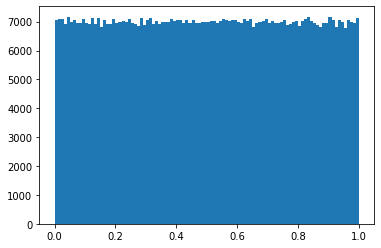

In [60]:
plt.hist(h,bins=100)
plt.show()

In [73]:
np.random.seed(10000)

In [74]:
k = np.random.rand(700000)

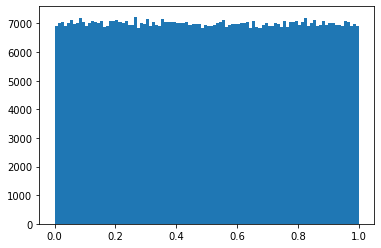

In [75]:
plt.hist(k,bins=100)
plt.show()

In [80]:
%time a = np.random.rand(100000)

CPU times: user 1.9 ms, sys: 736 µs, total: 2.63 ms
Wall time: 1.64 ms


In [85]:
%time a = np.random.rand(100000)

CPU times: user 1.97 ms, sys: 1.25 ms, total: 3.21 ms
Wall time: 1.79 ms
